## Beta
$\beta$ is the most important concept in modern finance. It measures market risk or systematic risk. Specifically, it uncovers how individual stock return correlates market performance. In a rational market, stock return should be determined by beta, i.e. stock return is the compensation for taking market risk.

Mathematically, $\beta$ can be presented as
$$\beta = \frac{Cov(R_i,R_{mkt})}{Var(R_{mkt})}$$
where $R_i$ is stock return and $R_{mkt}$ is market return

In [1]:
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.width', 180)
data_path = '/users/ml/git/'

### Read clean data
The speed of reading data should be faster than before because there is no mixed type for each variable. Therefore, computer does not need to allocate resource to guess the type of data.

In [3]:
crsp_monthly = pd.read_csv(data_path+'crsp_monthly_clean_1.txt', sep='\t')
permno_list = crsp_monthly.drop_duplicates(subset='permno')['permno']
print 'number of stocks: ' + str(len(permno_list))

number of stocks: 21134


In [4]:
stock_ret = crsp_monthly[(crsp_monthly['ret'].notnull()) & (crsp_monthly['vwretd'].notnull())][['permno','date','ret','vwretd']]
permno_list = stock_ret.drop_duplicates(subset='permno')['permno']
print 'number of stocks with valid return and market return: ' + str(len(permno_list))

number of stocks with valid return and market return: 21030


In [5]:
# Use at least 36-month historical information to estimate beta
permno_num = pd.DataFrame({'n': stock_ret.groupby('permno')['ret'].count()})
permno_num = permno_num[permno_num['n']>=36]
print 'number of stocks with at least 36-month valid data: ' + str(len(permno_num))

number of stocks with at least 36-month valid data: 15866


### Define OLS regression

In [6]:
def ols_reg(y,x):
    est = sm.OLS(y,sm.add_constant(x)).fit()
    return est

### Run OLS regression to estimate $\beta$ for each stock

In [7]:
beta = []
for i in permno_num.index:
    ret_data = stock_ret[stock_ret['permno']==i]
    est = ols_reg(ret_data['ret'],ret_data['vwretd'])
    beta.append((i,est.params[1]))

beta_1 = pd.DataFrame(beta, columns=['permno','beta'])
beta_1['beta'].describe()

count    15866.000000
mean         1.093985
std          0.755876
min         -3.861767
25%          0.620378
50%          1.015486
75%          1.467740
max          8.164364
Name: beta, dtype: float64

### Plot the distribution of $\beta$

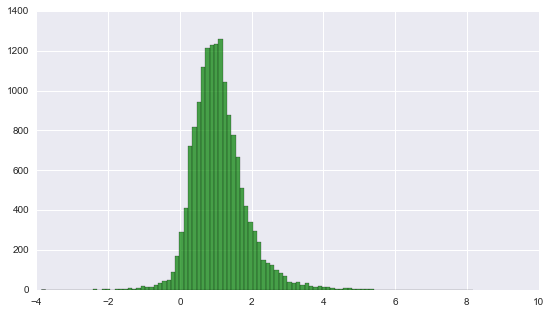

In [8]:
plt.close('all')
_,ax_beta = plt.subplots(1,1,figsize=(9,5))
beta_1['beta'].hist(bins=100,color='g', ax=ax_beta, alpha=0.7)
plt.show()

### Rolling $\beta$
Rolling $\beta$ can show the persistence of beta, i.e. whether $\beta$ is stable over time.

In [9]:
stock_ret_1 = stock_ret.pivot(index='date',columns='permno',values='ret')
stock_ret_1.columns = [str(i) for i in stock_ret_1.columns]
mktret = pd.DataFrame(stock_ret.drop_duplicates(subset='date')[['date','vwretd']])
mktret = mktret.sort_values('date')
mktret.index = mktret['date']
del mktret['date']
stock_ret_1 = stock_ret_1.join(mktret)

beta_rolling = []
window = 60 # rolling window: number of observation to estimate beta
''' Just try first 10 stocks '''
for i in stock_ret_1.columns[:10]:
    ret_data = stock_ret_1[[i,'vwretd']]
    ret_data = ret_data[(ret_data[i].notnull()) & (ret_data['vwretd'].notnull())]
    ret_data.sort_index(inplace=True)
    if len(ret_data) >= window:
        for j in range(len(ret_data)-window):
            est = ols_reg(ret_data.ix[ret_data.index[j:j+window-1],i],ret_data.ix[ret_data.index[j:j+window-1],'vwretd'])
            beta_rolling.append((i,ret_data.index[j+window-1],est.params[1]))

beta_rolling_1 = pd.DataFrame(beta_rolling,columns=['permno','date','beta'])

### Plot rolling $\beta$

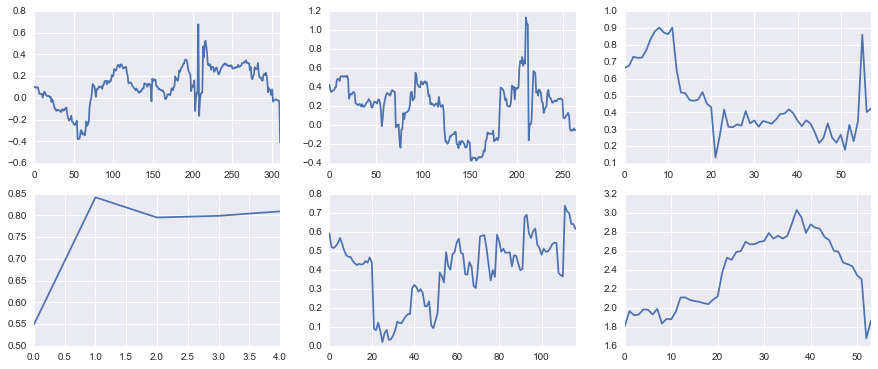

In [10]:
beta_stock_list = beta_rolling_1.drop_duplicates(subset='permno')['permno'].reset_index(drop=True)

plt.close('all')
_,axes = plt.subplots(2,3,figsize=(15,6))
for i,j in zip(axes.flatten(),beta_stock_list):
    pd.DataFrame(beta_rolling_1[beta_rolling_1['permno']==j]['beta']).reset_index(drop=True).plot(ax=i)
    i.legend([])

plt.show()

### Test the relation between $\beta$ and stock return
Market risk ($\beta$) is the only source of risk by holding stocks according to CAPM, therefore $\beta$ should positively associate with stock return

####  First step is to compute average return of each stock

In [11]:
stock_avg = pd.DataFrame({'ret': stock_ret.groupby('permno')['ret'].mean()})

#### Then we can run regression of $E(R_i) = \alpha + \gamma \beta_i + \epsilon_i$
We expect $\gamma$ is significantly positive

In [12]:
stock_avg['permno'] = stock_avg.index
stock_avg.reset_index(drop=True,inplace=True)
cross_section_reg = stock_avg.merge(beta_1,how='inner',on='permno')
b = ols_reg(cross_section_reg['ret'],cross_section_reg['beta'])
print b.summary()

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     204.3
Date:                Thu, 04 May 2017   Prob (F-statistic):           4.71e-46
Time:                        22:38:41   Log-Likelihood:                 39134.
No. Observations:               15866   AIC:                        -7.826e+04
Df Residuals:                   15864   BIC:                        -7.825e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0068      0.000     23.695      0.0